          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

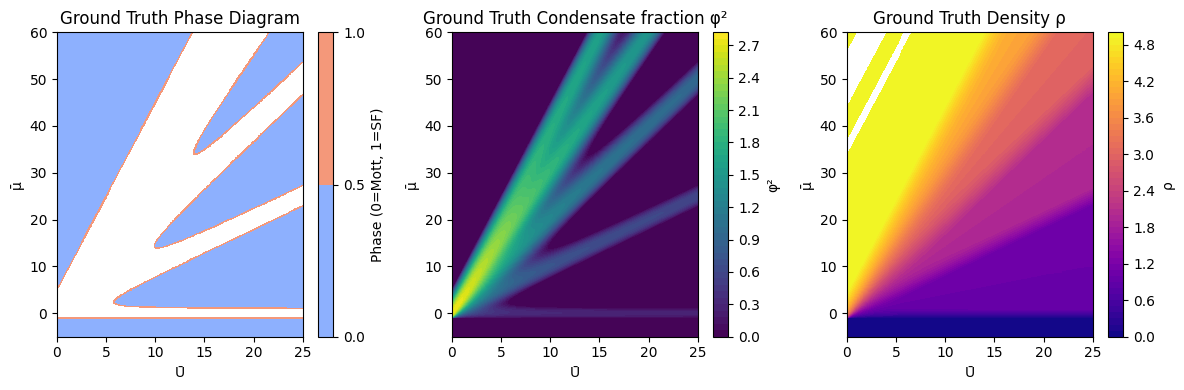

Epoch 1/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7420 - val_loss: 0.0853
Epoch 2/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5347 - val_loss: 0.1517
Epoch 3/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3202 - val_loss: 0.0704
Epoch 4/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2540 - val_loss: 0.0566
Epoch 5/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1958 - val_loss: 0.0401
Epoch 6/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1650 - val_loss: 0.0359
Epoch 7/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1452 - val_loss: 0.0389
Epoch 8/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1319 - val_loss: 0.0337
Epoch 9/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1210 - val_loss: 0.0346
Epoch 10/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1131 - val_loss: 0.0334
Epoch 11/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1056 - val_loss: 0.0316
Epoch 12/200
272/272 ━━━━━━━━━━━━━━━━━━━━

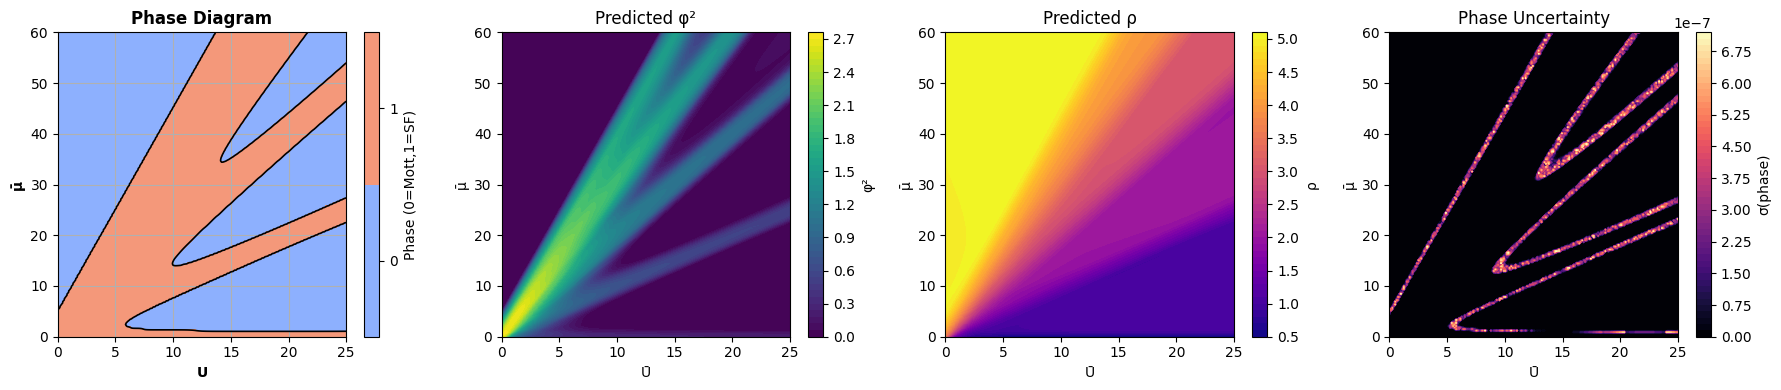

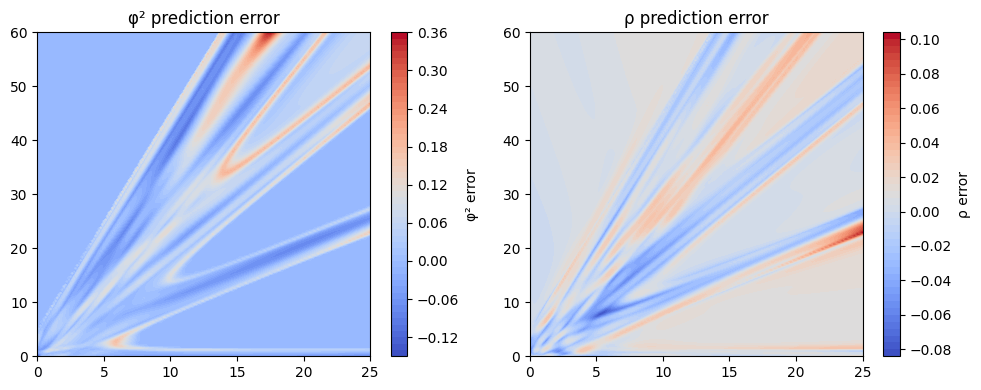

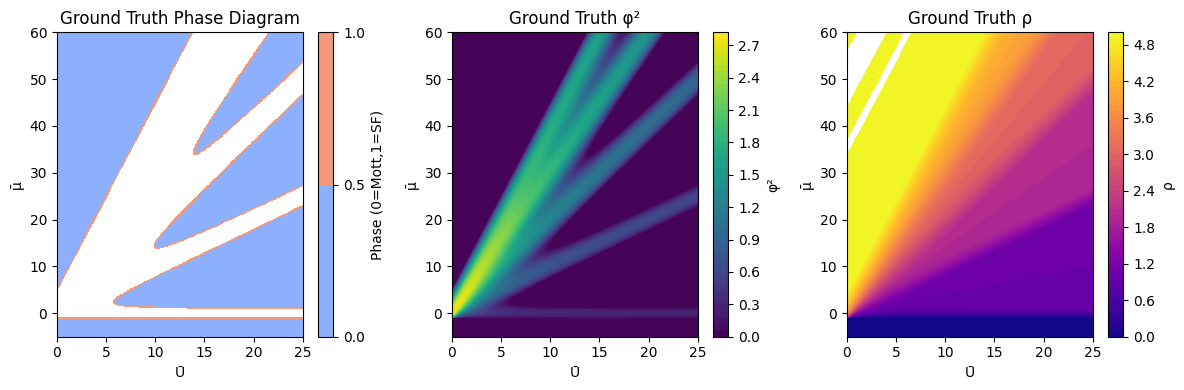


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9990    0.9894    0.9942     23172
           1     0.9856    0.9987    0.9921     16828

    accuracy                         0.9933     40000
   macro avg     0.9923    0.9941    0.9932     40000
weighted avg     0.9934    0.9933    0.9933     40000



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

# df_MI = df[
#     (df["Phi2"] < 1e-8) &
#     (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
# ]

# # --- pick deep SF (large phi2) ---
# df_SF = df[df["Phi2"] > 1e-2]

# # --- pick boundary (ambiguous region) ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
# ]

# ------------------------------
# Smart sampling strategy
# # ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# # n_MI = min(5000, len(df_MI))
# # n_SF = min(5000, len(df_SF))
# # n_boundary = min(10000, len(df_boundary))

# # n_MI = min(3000, len(df_MI))
# # n_SF = min(3000, len(df_SF))
# # n_boundary = min(6000, len(df_boundary))


# df_reduced = pd.concat([
#     df_MI.sample(n_MI, random_state=42),
#     df_SF.sample(n_SF, random_state=42),
#     df_boundary.sample(n_boundary, random_state=42)
# ])
# print(df)
# df_reduced = df_reduced.reset_index(drop=True)
# # Use reduced dataset
# df = df_reduced.reset_index(drop=True)
# print(df)


# print("Reduced dataset summary:")
# print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('Full-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



In [2]:
import pandas as pd
import numpy as np

def extract_boundaries_and_compare(df, U_vals, mu_vals, phase_map, U_targets=[10, 15, 20, 25]):
    """
    Extract actual and predicted boundaries from dataset & phase_map, then compare.
    
    Parameters
    ----------
    df : pd.DataFrame
        Original dataset with 'Ubar', 'Mubar', 'Phase' columns.
    U_vals : np.ndarray
        Grid values of U used for prediction.
    mu_vals : np.ndarray
        Grid values of μ used for prediction.
    phase_map : np.ndarray
        Predicted phase map on grid (shape: len(mu_vals) x len(U_vals)).
    U_targets : list
        Specific U values for which to extract boundaries.
    
    Returns
    -------
    actual_boundary_df : pd.DataFrame
    predicted_boundary_df : pd.DataFrame
    comparison_df : pd.DataFrame
    """
    
    # ---------- 1) Actual boundaries ----------
    boundary_points_true = []
    for U, group in df.groupby("Ubar"):
        group_sorted = group.sort_values("Mubar")
        phase_vals = group_sorted["Phase"].values
        mu_vals_sorted = group_sorted["Mubar"].values
        transitions = np.where(np.diff(phase_vals) != 0)[0]
        for t in transitions:
            mu_b = (mu_vals_sorted[t] + mu_vals_sorted[t+1]) / 2
            boundary_points_true.append((U, mu_b))
    
    actual_boundary_df = pd.DataFrame(boundary_points_true, columns=["Ubar", "Mubar"])
    actual_phase_list = []
    pred_phase_list = []
    
    for _, row in actual_boundary_df.iterrows():
        U, mu = row["Ubar"], row["Mubar"]
        # Nearest actual phase
        nearest = df.iloc[((df["Ubar"] - U)**2 + (df["Mubar"] - mu)**2).argmin()]
        actual_phase_list.append(nearest["Phase"])
        # Predicted phase from phase_map
        i = np.abs(U_vals - U).argmin()
        j = np.abs(mu_vals - mu).argmin()
        pred_phase_list.append(phase_map[j, i])
    
    actual_boundary_df["Actual_Phase"] = actual_phase_list
    actual_boundary_df["Predicted_Phase"] = pred_phase_list
    actual_boundary_df["Type"] = "Actual"
    
    # ---------- 2) Predicted boundaries ----------
    boundary_pred_points = []
    for i, U in enumerate(U_vals):
        phase_col = phase_map[:, i]
        transitions = np.where(np.diff(phase_col) != 0)[0]
        for t in transitions:
            mu_b = (mu_vals[t] + mu_vals[t+1]) / 2
            boundary_pred_points.append((U, mu_b))
    
    predicted_boundary_df = pd.DataFrame(boundary_pred_points, columns=["Ubar", "Mubar"])
    actual_phase_list_pred = []
    pred_phase_list_pred = []
    
    for _, row in predicted_boundary_df.iterrows():
        U, mu = row["Ubar"], row["Mubar"]
        # Nearest actual phase
        nearest = df.iloc[((df["Ubar"] - U)**2 + (df["Mubar"] - mu)**2).argmin()]
        actual_phase_list_pred.append(nearest["Phase"])
        # Predicted phase from phase_map
        i = np.abs(U_vals - U).argmin()
        j = np.abs(mu_vals - mu).argmin()
        pred_phase_list_pred.append(phase_map[j, i])
    
    predicted_boundary_df["Actual_Phase"] = actual_phase_list_pred
    predicted_boundary_df["Predicted_Phase"] = pred_phase_list_pred
    predicted_boundary_df["Type"] = "Predicted"
    
    # ---------- 3) Filter and align selected U boundaries ----------
    actual_boundary_selected = actual_boundary_df[actual_boundary_df["Ubar"].isin(U_targets)].sort_values(["Ubar", "Mubar"])
    predicted_boundary_selected = predicted_boundary_df[predicted_boundary_df["Ubar"].isin(U_targets)].sort_values(["Ubar", "Mubar"])
    
    # Remove negative μ
    actual_boundary_pos = actual_boundary_selected[actual_boundary_selected["Mubar"] >= 0].copy()
    predicted_boundary_pos = predicted_boundary_selected[predicted_boundary_selected["Mubar"] >= 0].copy()
    
    # Align boundaries and compute delta
    comparison_rows = []
    for U in U_targets:
        mu_actual = np.sort(actual_boundary_pos[actual_boundary_pos["Ubar"]==U]["Mubar"].values)
        mu_pred = np.sort(predicted_boundary_pos[predicted_boundary_pos["Ubar"]==U]["Mubar"].values)
        n_points = min(len(mu_actual), len(mu_pred))
        for i in range(n_points):
            mu_a, mu_p = mu_actual[i], mu_pred[i]
            actual_phase = actual_boundary_pos[(actual_boundary_pos["Ubar"]==U) & (actual_boundary_pos["Mubar"]==mu_a)]["Actual_Phase"].values[0]
            predicted_phase = predicted_boundary_pos[(predicted_boundary_pos["Ubar"]==U) & (predicted_boundary_pos["Mubar"]==mu_p)]["Predicted_Phase"].values[0]
            comparison_rows.append([U, mu_a, mu_p, actual_phase, predicted_phase, mu_a - mu_p])
    
    comparison_df = pd.DataFrame(comparison_rows, columns=["Ubar", "Actual_Mu", "Predicted_Mu", "Actual_Phase", "Predicted_Phase", "Delta_Mu"])
    comparison_df = comparison_df.sort_values(["Ubar", "Actual_Mu"])
    
    return actual_boundary_df, predicted_boundary_df, comparison_df


In [3]:
actual_df, predicted_df, comparison_df = extract_boundaries_and_compare(
    df=df,
    U_vals=U_vals,
    mu_vals=mu_vals,
    phase_map=phase_pred_class,  # <- use this
    U_targets=[10, 15, 20, 25]
)



In [7]:
actual_df.to_csv("actual_boundary_points-pinn-by.csv", index=False)
predicted_df.to_csv("predicted_boundary_points-pinn-by.csv", index=False)
comparison_df.to_csv("boundary_mu_comparison_aligned-pinn-by.csv", index=False)


In [7]:
actual_df, predicted_df, comparison_df = extract_boundaries_and_compare(
    df=df,
    U_vals=U_vals,
    mu_vals=mu_vals,
    phase_map=phase_pred_class,  # <- use this
    U_targets=[5.9]
)

print("actual",actual_df)
print("predicted",predicted_df)
print(comparison_df)


actual       Ubar  Mubar  Actual_Phase  Predicted_Phase    Type
0      0.0  -1.05           0.0                1  Actual
1      0.0   5.05           1.0                0  Actual
2      0.1  -1.05           0.0                1  Actual
3      0.1   5.45           1.0                1  Actual
4      0.2  -1.05           0.0                1  Actual
...    ...    ...           ...              ...     ...
1258  25.0   1.05           0.0                1  Actual
1259  25.0  22.95           0.0                1  Actual
1260  25.0  27.35           1.0                0  Actual
1261  25.0  46.65           1.0                1  Actual
1262  25.0  53.65           0.0                1  Actual

[1263 rows x 5 columns]
predicted           Ubar      Mubar  Actual_Phase  Predicted_Phase       Type
0     0.000000   4.974874           1.0                1  Predicted
1     0.125628   5.577889           0.0                1  Predicted
2     0.251256   6.180905           1.0                1  Predicted
3 